Total images loaded: 663
Epoch 1/100 | Loss_D: -32.94644546508789 | Loss_G: 15.12679672241211
Epoch 2/100 | Loss_D: -51.16886901855469 | Loss_G: 24.093034744262695
Epoch 3/100 | Loss_D: -67.34439849853516 | Loss_G: 31.45398712158203
Epoch 4/100 | Loss_D: -81.65809631347656 | Loss_G: 37.57248306274414
Epoch 5/100 | Loss_D: -90.80377197265625 | Loss_G: 42.90078353881836
Epoch 6/100 | Loss_D: -100.88478088378906 | Loss_G: 47.74190139770508
Epoch 7/100 | Loss_D: -111.73773193359375 | Loss_G: 52.18496322631836
Epoch 8/100 | Loss_D: -119.69465637207031 | Loss_G: 56.31304931640625
Epoch 9/100 | Loss_D: -124.40208435058594 | Loss_G: 60.01787567138672
Epoch 10/100 | Loss_D: -128.35589599609375 | Loss_G: 62.46917724609375
Epoch 11/100 | Loss_D: -135.59237670898438 | Loss_G: 64.55873107910156
Epoch 12/100 | Loss_D: -151.05081176757812 | Loss_G: 72.29493713378906
Epoch 13/100 | Loss_D: -135.0894317626953 | Loss_G: 67.08797454833984
Epoch 14/100 | Loss_D: -124.93572235107422 | Loss_G: 67.5578994750

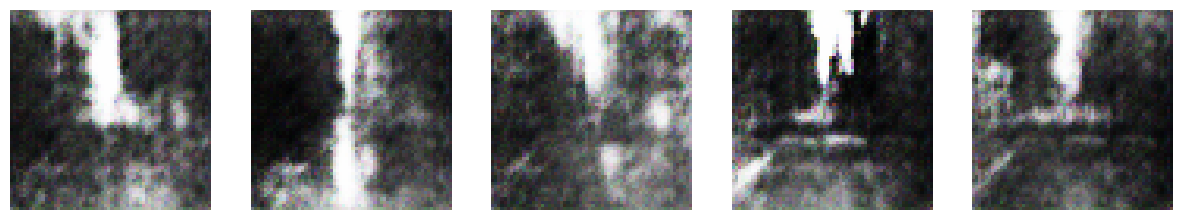

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, ConcatDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_dirs = [
    "/content/drive/MyDrive/2011_09_26_drive_0001_extract/image_00",
    "/content/drive/MyDrive/2011_09_26_drive_0020_sync/2011_09_26/2011_09_26_drive_0020_sync/image_00",
    "/content/drive/MyDrive/2011_09_26_drive_0027_sync/2011_09_26/2011_09_26_drive_0027_sync/image_00",
    "/content/drive/MyDrive/2011_09_26_drive_0119_extract/2011_09_26/2011_09_26_drive_0119_extract/image_00",
    "/content/drive/MyDrive/2011_09_28_drive_0021_sync/2011_09_28/2011_09_28_drive_0021_sync/image_00",
    "/content/drive/MyDrive/2011_09_28_drive_0054_sync/2011_09_28/2011_09_28_drive_0054_sync/image_00"
]

datasets_list = [datasets.ImageFolder(root=folder, transform=transform) for folder in dataset_dirs if os.path.exists(folder)]
full_dataset = ConcatDataset(datasets_list)
dataloader = DataLoader(full_dataset, batch_size=64, shuffle=True)

print(f"Total images loaded: {len(full_dataset)}")

# Improved Generator with Feature Matching
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)

# Improved Discriminator with Minibatch Discrimination
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )
    def forward(self, x):
        return self.model(x).view(-1, 1)

# Wasserstein Loss
class WassersteinLoss(nn.Module):
    def forward(self, real_scores, fake_scores):
        return real_scores.mean() - fake_scores.mean()

generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)
loss_fn = WassersteinLoss()

# Training
num_epochs = 100
fixed_noise = torch.randn(25, 100, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = generator(noise)
        real_scores = discriminator(real_images)
        fake_scores = discriminator(fake_images.detach())
        loss_D = -loss_fn(real_scores, fake_scores)
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_scores = discriminator(fake_images)
        loss_G = -fake_scores.mean()
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss_D: {loss_D.item()} | Loss_G: {loss_G.item()}")

    if epoch % 10 == 0:
        with torch.no_grad():
            fake_samples = generator(fixed_noise).cpu()
        vutils.save_image(fake_samples, f"/content/generated_epoch_{epoch}.png", normalize=True)

# Final Visualization
def denormalize(img):
    return img * 0.5 + 0.5  # Convert from (-1,1) to (0,1)

with torch.no_grad():
    fake_samples = generator(fixed_noise).cpu()

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(fake_samples[:5]):
    axs[i].imshow(denormalize(img.permute(1, 2, 0)).numpy())  # Fix image range
    axs[i].axis('off')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pytorch-msssim


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, ConcatDataset
from pytorch_msssim import ssim
import torch.nn.functional as F

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ✅ Load Datasets from multiple directories
dataset_dirs = [
    "/content/drive/MyDrive/2011_09_26_drive_0001_extract/image_02",
    "/content/drive/MyDrive/2011_09_26_drive_0001_extract/image_03",
    "/content/drive/MyDrive/2011_09_26_drive_0020_sync/2011_09_26/2011_09_26_drive_0020_sync/image_02",
    "/content/drive/MyDrive/2011_09_26_drive_0020_sync/2011_09_26/2011_09_26_drive_0020_sync/image_03",
    "/content/drive/MyDrive/2011_09_26_drive_0027_sync/2011_09_26/2011_09_26_drive_0027_sync/image_02",
    "/content/drive/MyDrive/2011_09_26_drive_0027_sync/2011_09_26/2011_09_26_drive_0027_sync/image_03",
    "/content/drive/MyDrive/2011_09_28_drive_0021_sync/2011_09_28/2011_09_28_drive_0021_sync/image_02",
    "/content/drive/MyDrive/2011_09_28_drive_0021_sync/2011_09_28/2011_09_28_drive_0021_sync/image_03",
    "/content/drive/MyDrive/2011_09_28_drive_0054_sync/2011_09_28/2011_09_28_drive_0054_sync/image_02",
    "/content/drive/MyDrive/2011_09_28_drive_0054_sync/2011_09_28/2011_09_28_drive_0054_sync/image_03"
]

datasets_list = [datasets.ImageFolder(root=folder, transform=transform) for folder in dataset_dirs if os.path.exists(folder)]
full_dataset = ConcatDataset(datasets_list)
dataloader = DataLoader(full_dataset, batch_size=64, shuffle=True)

print(f"Total images loaded: {len(full_dataset)}")

# ✅ Minibatch Discrimination Layer (Fixed)
class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.T = nn.Parameter(torch.randn(in_features, out_features))

    def forward(self, x):
        M = x @ self.T  # Compute dot product
        diffs = M.unsqueeze(0) - M.unsqueeze(1)  # Compute differences
        abs_diffs = torch.sum(torch.abs(diffs), dim=2)  # Sum over feature dimensions
        exp_diffs = torch.exp(-abs_diffs)  # Apply exponentiation

        # Calculate the mean across dimension 1 and keep the dimension
        minibatch_features = exp_diffs.mean(1, keepdim=True)  # This now has shape (batch_size, 1)
        return torch.cat((x, minibatch_features), dim=1)  # Concatenate

# ✅ Generator Network (Updated)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(50, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# ✅ Updated Discriminator with Minibatch Discrimination
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten()
        )

        self.feature_size = 512 * 4 * 4  # 8192
        self.minibatch_discrimination = MinibatchDiscrimination(self.feature_size, 100)  # Output 100 features for minibatch discrim

        # ✅ Correct the input size to the classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size + 1, 1),   # Adjusted input size to feature_size + 1
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.feature_extractor(x)  # Shape: (batch_size, 8192)
        x = self.minibatch_discrimination(x)  # Shape: (batch_size, 8193) now!!!
        x = self.classifier(x)  # Shape: (batch_size, 1)
        return x

# ✅ Initialize Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# ✅ Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# ✅ Loss Function
criterion = nn.BCELoss()

# ✅ Training Loop
num_epochs = 50
fixed_noise = torch.randn(25, 50, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # 🎯 Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        optimizer_D.zero_grad()
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, 50, 1, 1, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # 🎯 Train Generator
        optimizer_G.zero_grad()
        output_fake = discriminator(fake_images)
        perceptual_loss = F.l1_loss(fake_images, real_images[:batch_size])
        loss_G = criterion(output_fake, real_labels) + 0.1 * perceptual_loss

        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss_D: {loss_D.item()} | Loss_G: {loss_G.item()}")

    if epoch % 10 == 0:
        with torch.no_grad():
            fake_samples = generator(fixed_noise).cpu()
        vutils.save_image(fake_samples, f"/content/generated_epoch_{epoch}.png", normalize=True)

# ✅ Compute Evaluation Metrics
def compute_metrics(fake_images, real_images):
    mse = torch.mean((fake_images - real_images) ** 2)
    psnr = 10 * torch.log10(1 / mse)
    ssim_value = ssim(fake_images, real_images)
    return psnr.item(), ssim_value.item()

real_images, _ = next(iter(dataloader))
real_images = real_images.to(device)[:25]
fake_images = generator(fixed_noise)

psnr, ssim_score = compute_metrics(fake_images, real_images)

print(f"🔹 PSNR: {psnr:.2f}")
print(f"🔹 SSIM: {ssim_score:.4f}")


Total images loaded: 1292
Epoch 1/50 | Loss_D: 0.14113280177116394 | Loss_G: 5.376626491546631
Epoch 2/50 | Loss_D: 0.6265115141868591 | Loss_G: 10.533397674560547
Epoch 3/50 | Loss_D: 0.6908042430877686 | Loss_G: 9.978533744812012
Epoch 4/50 | Loss_D: 0.48639240860939026 | Loss_G: 7.681637763977051
Epoch 5/50 | Loss_D: 0.06057567149400711 | Loss_G: 7.128548622131348
Epoch 6/50 | Loss_D: 0.12709248065948486 | Loss_G: 5.515970230102539
Epoch 7/50 | Loss_D: 0.14800819754600525 | Loss_G: 5.7036566734313965
Epoch 8/50 | Loss_D: 0.06776031851768494 | Loss_G: 5.605539321899414
Epoch 9/50 | Loss_D: 0.06644183397293091 | Loss_G: 5.606732368469238
Epoch 10/50 | Loss_D: 0.029366865754127502 | Loss_G: 5.7324395179748535
Epoch 11/50 | Loss_D: 0.14199310541152954 | Loss_G: 4.890027046203613
Epoch 12/50 | Loss_D: 2.3530709743499756 | Loss_G: 12.304659843444824
Epoch 13/50 | Loss_D: 0.03824765980243683 | Loss_G: 4.757993698120117
Epoch 14/50 | Loss_D: 0.24388320744037628 | Loss_G: 3.3047192096710205


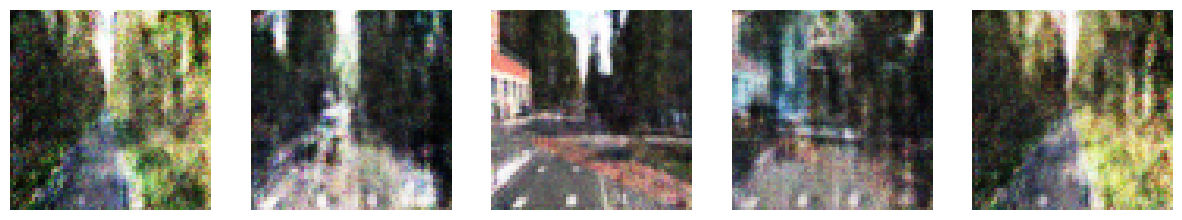

In [ ]:
# Final Visualization
def denormalize(img):
    return img * 0.5 + 0.5  # Convert from (-1,1) to (0,1)

with torch.no_grad():
    fake_samples = generator(fixed_noise).cpu()

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(fake_samples[:5]):
    axs[i].imshow(denormalize(img.permute(1, 2, 0)).numpy())  # Fix image range
    axs[i].axis('off')
plt.show()


In [ ]:
!git clone https://github.com/xinntao/Real-ESRGAN
!pip install -r Real-ESRGAN/requirements.txt
%cd Real-ESRGAN
!python setup.py develop


Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Total 759 (delta 0), reused 0 (delta 0), pack-reused 759 (from 1)
Receiving objects: 100% (759/759), 5.39 MiB | 8.31 MiB/s, done.
Resolving deltas: 100% (407/407), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, ConcatDataset
from pytorch_msssim import ssim
import torch.nn.functional as F

# ✅ Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Data Transform (Resize and Normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ✅ Dataset Paths (Add the correct paths)
dataset_dirs = [
    "/content/drive/MyDrive/2011_09_26_drive_0001_extract/image_02",
    "/content/drive/MyDrive/2011_09_26_drive_0001_extract/image_03",
    "/content/drive/MyDrive/2011_09_26_drive_0020_sync/2011_09_26/2011_09_26_drive_0020_sync/image_02",
    "/content/drive/MyDrive/2011_09_26_drive_0020_sync/2011_09_26/2011_09_26_drive_0020_sync/image_03",
    "/content/drive/MyDrive/2011_09_26_drive_0027_sync/2011_09_26/2011_09_26_drive_0027_sync/image_02",
    "/content/drive/MyDrive/2011_09_26_drive_0027_sync/2011_09_26/2011_09_26_drive_0027_sync/image_03",
    "/content/drive/MyDrive/2011_09_28_drive_0021_sync/2011_09_28/2011_09_28_drive_0021_sync/image_02",
    "/content/drive/MyDrive/2011_09_28_drive_0021_sync/2011_09_28/2011_09_28_drive_0021_sync/image_03",
    "/content/drive/MyDrive/2011_09_28_drive_0054_sync/2011_09_28/2011_09_28_drive_0054_sync/image_02",
    "/content/drive/MyDrive/2011_09_28_drive_0054_sync/2011_09_28/2011_09_28_drive_0054_sync/image_03"
]

datasets_list = [datasets.ImageFolder(root=folder, transform=transform) for folder in dataset_dirs if os.path.exists(folder)]
full_dataset = ConcatDataset(datasets_list)
dataloader = DataLoader(full_dataset, batch_size=64, shuffle=True)

print(f"Total images loaded: {len(full_dataset)}")

# ✅ Minibatch Discrimination Class
class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.T = nn.Parameter(torch.randn(in_features, out_features))

    def forward(self, x):
        M = x @ self.T
        diffs = M.unsqueeze(0) - M.unsqueeze(1)
        abs_diffs = torch.sum(torch.abs(diffs), dim=2)
        exp_diffs = torch.exp(-abs_diffs)
        minibatch_features = exp_diffs.mean(1, keepdim=True)
        return torch.cat((x, minibatch_features), dim=1)

# ✅ Generator Class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# ✅ Discriminator Class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()
        )
        self.feature_size = 1024 * 4 * 4
        self.minibatch_discrimination = MinibatchDiscrimination(self.feature_size, 100)
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size + 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.minibatch_discrimination(x)
        x = self.classifier(x)
        return x

# ✅ Initialize Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# ✅ Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# ✅ LR Scheduler
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.5)

# ✅ Loss Function
criterion = nn.BCELoss()

# ✅ Training Loop
num_epochs = 100
fixed_noise = torch.randn(25, 100, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # 🎯 Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        optimizer_D.zero_grad()
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # 🎯 Generator
        optimizer_G.zero_grad()
        output_fake = discriminator(fake_images)
        perceptual_loss = F.l1_loss(fake_images, real_images[:batch_size])
        loss_G = criterion(output_fake, real_labels) + 0.1 * perceptual_loss

        loss_G.backward()
        optimizer_G.step()

    scheduler_G.step()
    scheduler_D.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")

    # Save generated images every 10 epochs
    if epoch % 10 == 0:
        with torch.no_grad():
            fake_samples = generator(fixed_noise).cpu()
        vutils.save_image(fake_samples, f"/content/generated_epoch_{epoch}.png", normalize=True)

# ✅ PSNR & SSIM Calculation
def compute_metrics(fake_images, real_images):
    mse = torch.mean((fake_images - real_images) ** 2)
    psnr = 10 * torch.log10(1 / mse)
    ssim_value = ssim(fake_images, real_images)
    return psnr.item(), ssim_value.item()

real_images, _ = next(iter(dataloader))
real_images = real_images.to(device)[:25]
fake_images = generator(fixed_noise)

psnr, ssim_score = compute_metrics(fake_images, real_images)
print(f"🔹 PSNR: {psnr:.2f}")
print(f"🔹 SSIM: {ssim_score:.4f}")


Total images loaded: 1292
Epoch 1/100 | Loss_D: 0.0214 | Loss_G: 8.5432
Epoch 2/100 | Loss_D: 0.0108 | Loss_G: 10.0348
Epoch 3/100 | Loss_D: 0.0038 | Loss_G: 12.0679
Epoch 4/100 | Loss_D: 0.0005 | Loss_G: 22.7893
Epoch 5/100 | Loss_D: 0.0022 | Loss_G: 10.9954
Epoch 6/100 | Loss_D: 0.0028 | Loss_G: 17.7502
Epoch 7/100 | Loss_D: 0.0316 | Loss_G: 18.9069
Epoch 8/100 | Loss_D: 0.2551 | Loss_G: 7.4590
Epoch 9/100 | Loss_D: 0.0028 | Loss_G: 10.3028
Epoch 10/100 | Loss_D: 0.0038 | Loss_G: 6.5582
Epoch 11/100 | Loss_D: 1.0564 | Loss_G: 13.7233
Epoch 12/100 | Loss_D: 0.3552 | Loss_G: 7.5714
Epoch 13/100 | Loss_D: 0.0137 | Loss_G: 5.7734
Epoch 14/100 | Loss_D: 0.3556 | Loss_G: 4.9891
Epoch 15/100 | Loss_D: 0.0991 | Loss_G: 6.4846
Epoch 16/100 | Loss_D: 0.2275 | Loss_G: 4.4184
Epoch 17/100 | Loss_D: 0.3026 | Loss_G: 4.8049
Epoch 18/100 | Loss_D: 1.3584 | Loss_G: 0.0783
Epoch 19/100 | Loss_D: 0.0335 | Loss_G: 5.4468
Epoch 20/100 | Loss_D: 0.1265 | Loss_G: 4.0433
Epoch 21/100 | Loss_D: 0.4606 | Los

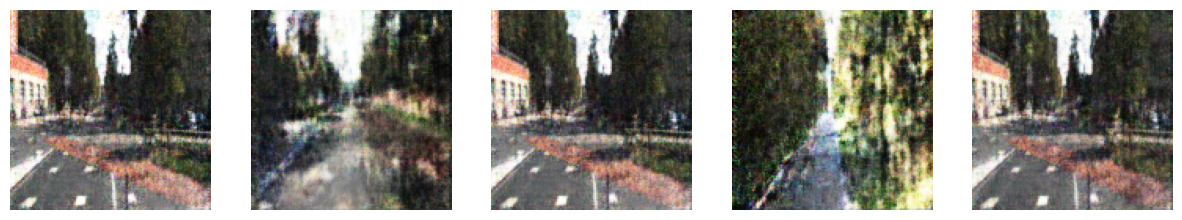

In [ ]:
# Final Visualization
def denormalize(img):
    return img * 0.5 + 0.5  # Convert from (-1,1) to (0,1)

with torch.no_grad():
    fake_samples = generator(fixed_noise).cpu()

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(fake_samples[:5]):
    axs[i].imshow(denormalize(img.permute(1, 2, 0)).numpy())  # Fix image range
    axs[i].axis('off')
plt.show()


In [ ]:
!python inference_realesrgan.py -n RealESRGAN_x4plus -i /content/generated_epoch_90.png -o /content/upscaled


Traceback (most recent call last):
  File "/content/Real-ESRGAN/Real-ESRGAN/inference_realesrgan.py", line 5, in <module>
    from basicsr.archs.rrdbnet_arch import RRDBNet
  File "/usr/local/lib/python3.11/dist-packages/basicsr/__init__.py", line 4, in <module>
    from .data import *
  File "/usr/local/lib/python3.11/dist-packages/basicsr/data/__init__.py", line 22, in <module>
    _dataset_modules = [importlib.import_module(f'basicsr.data.{file_name}') for file_name in dataset_filenames]
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/basicsr/data/__init__.py", line 22, in <listcomp>
    _dataset_modules = [importlib.import_module(f'basicsr.data.{file_name}') for file_name in dataset_filenames]
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._g

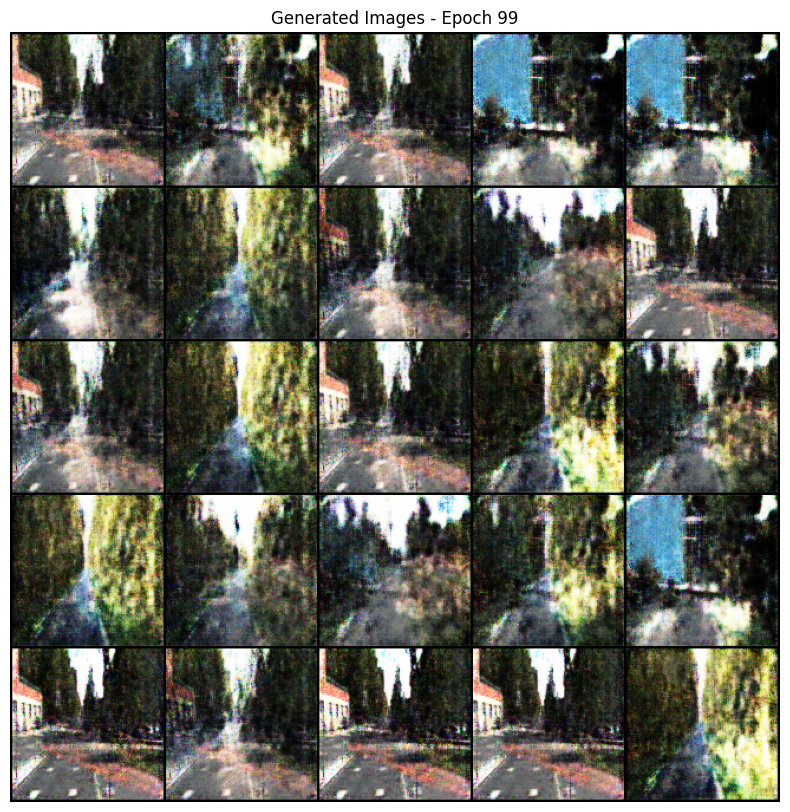

In [ ]:
vutils.save_image(fake_samples, f"/content/generated_epoch_{epoch}.png", normalize=True)
import matplotlib.pyplot as plt
import torchvision

# Show the image grid
grid = torchvision.utils.make_grid(fake_samples, nrow=5, normalize=True)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title(f"Generated Images - Epoch {epoch}")
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
plt.show()


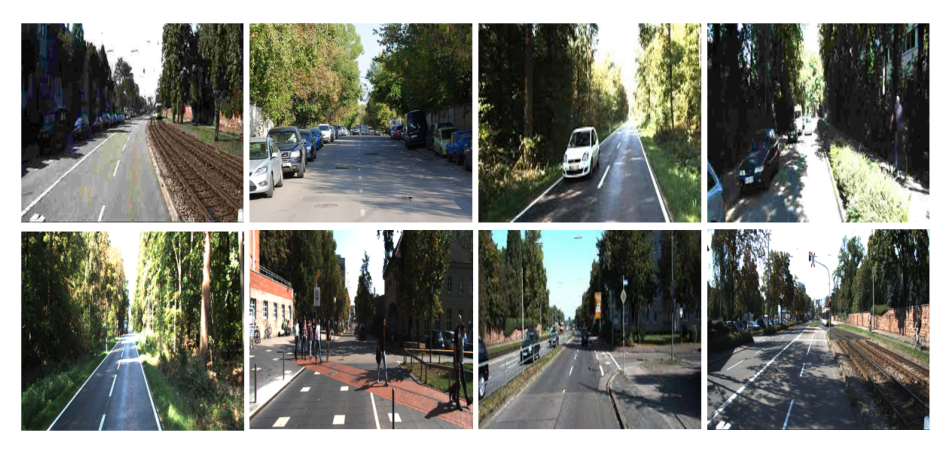

In [2]:
# Final Visualization
def denormalize(img):
    return img * 0.5 + 0.5  # Convert from (-1,1) to (0,1)

with torch.no_grad():
    fake_samples = generator(fixed_noise).cpu()

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(fake_samples[:5]):
    axs[i].imshow(denormalize(img.permute(1, 2, 0)).numpy())  # Fix image range
    axs[i].axis('off')
plt.show()